In [1]:
import sys
sys.path.append('../lib')
sys.path.append('../src')
sys.path.append('../src/queries')
sys.path.append('../src/clustering')
sys.path.append('../data')
sys.path.append('../')

%matplotlib inline

from lib import csv_reader as reader
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

from lib import year_classifier as year_classifier
sys.path

['',
 '/home/l/lemkec/anaconda3/envs/python2/lib/python27.zip',
 '/home/l/lemkec/anaconda3/envs/python2/lib/python2.7',
 '/home/l/lemkec/anaconda3/envs/python2/lib/python2.7/plat-linux2',
 '/home/l/lemkec/anaconda3/envs/python2/lib/python2.7/lib-tk',
 '/home/l/lemkec/anaconda3/envs/python2/lib/python2.7/lib-old',
 '/home/l/lemkec/anaconda3/envs/python2/lib/python2.7/lib-dynload',
 '/home/l/lemkec/.local/lib/python2.7/site-packages',
 '/home/l/lemkec/anaconda3/envs/python2/lib/python2.7/site-packages',
 '/home/l/lemkec/anaconda3/envs/python2/lib/python2.7/site-packages/Sphinx-1.4.6-py2.7.egg',
 '/home/l/lemkec/anaconda3/envs/python2/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg',
 '/home/l/lemkec/.local/lib/python2.7/site-packages/IPython/extensions',
 '/home/l/lemkec/.ipython',
 '../lib',
 '../src',
 '../src/queries',
 '../src/clustering',
 '../data',
 '../']

Db initialized, data is now accessible. It took  0.47s reading all files


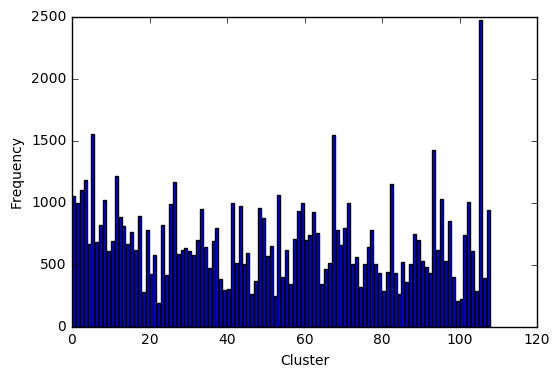

In [2]:
import db
import numpy as np
from matplotlib import pyplot as plt



my_db = db.Db()
cplt = my_db.clusters_long_19.groupby('cluster_id').count()
ar = [clusterCount[0] for clusterCount in np.array(cplt)]
plt.bar(range(0,len(ar)),ar)
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

In [3]:
#-*- coding: utf-8 -*-
import csv
import lib.csv_reader as csvr
import pandas as pd
from src.clustering import topic_mining as tm
import year_classifier as yc
from time import time

t0 = time()
csv_reader = csvr.CSV_reader()
metadata = csv_reader.get_metadata_dic()
metadata_clean = yc.year_classifier().get_classified_years_dic(metadata)
metadata_clean_kv = [(k,v['metadata_name'], v['metadata_surname'], v['metadata_location'], v['from_year'], v['to_year']) for k, v in metadata_clean.iteritems()]
tags = csv_reader.get_tags()
print('reading csv files took: {}s'.format((time()-t0)))

# Create SQL-like tables
t0 = time()
metadata_table = pd.DataFrame(metadata_clean_kv, columns=['picture_id', 'metadata_name', 'metadata_surname',
                                                          'metadata_location', 'from_year', 'to_year'])
tag_table = pd.DataFrame(tags, columns=csv_reader.tags_labels)


# Tables restricted to the long 19th century
metadata_table_long_nineteenth_century = metadata_table.query('from_year >= 1785 and to_year <= 1918', inplace=False)
tag_table_long_nineteenth_century = tag_table[(tag_table['picture_id']
                                               .isin(metadata_table_long_nineteenth_century['picture_id']))]

# Tags only
tags_grouped = tag_table_long_nineteenth_century.groupby('picture_id', as_index=False)
tags_grouped = tags_grouped.aggregate(lambda x: list(x))
tags_recomputed = [sum(map(lambda t, c: int(c)*[t], a, b), []) for (a, b) in zip(tags_grouped['tag_tag'].values.tolist(),
                                                                                 tags_grouped['tag_count'].values.tolist())]
tags_recomputed_keys = tags_grouped['picture_id'].values
print('Setting up DataFrames took: {}s'.format((time()-t0)))

# Stats
print('Kept {0:0.2f} % of tag data'.format((tag_table_long_nineteenth_century.shape[0] /
                                                float(tag_table.shape[0])) * 100))

print('kept {0:0.2f} % of metadata'.format((metadata_table_long_nineteenth_century.shape[0] /
                                                 float(metadata_table.shape[0])) * 100))

# Topic Mining
t0 = time()
topic_miner = tm.TopicMiner(n_topics=42, max_features=3500, topics_per_document=1, top_words=12)
data = [(' '.join(row)) for row in tags_recomputed]
topics = topic_miner.fit(data)
print('Mining topics took: {}s'.format((time()-t0)))
print('TopicMiner extracted the following topics: \n')
for topic in topics:
    print(topic)

# Creating a cluster table
#(picture_id, clusterid)
t0 = time()
clusters_long_nineteenth_century = []
for idx, v in enumerate(topic_miner.tfidf):
    clusters = topic_miner.predict(v)
    picture_id = tags_recomputed_keys[idx]
    for c in clusters:
        clusters_long_nineteenth_century.append((picture_id, c))

cluster_table_long_nineteenth_century = pd.DataFrame(clusters_long_nineteenth_century, columns=['picture_id', 'cluster_id'])
print('Predicting topics took: {}s'.format((time()-t0)))



def write_tables_to_csv(table, path):
    with open(path, 'wb') as csv_file:
        csv_writer = csv.writer(csv_file)
        for row in table:
            row_ = row.encode('utf-8')
            csv_writer.writerow(row_)

if(False):
    t0 = time()
    tag_table_long_nineteenth_century.to_csv(path_or_buf='tags_long_19.csv', index=False)
    metadata_table_long_nineteenth_century.to_csv(path_or_buf='metadata_long_19.csv', index=False)
    cluster_table_long_nineteenth_century.to_csv('clusters_long_19.csv', index=False)
    write_tables_to_csv(topics, 'topics.txt')
    print('Writing csv files took: {}s'.format((time()-t0)))


KeyboardInterrupt: 

In [4]:
# 34 krieg

In [2]:
meta_tag_df = pd.merge(my_db.metadata_long_19, my_db.clusters_long_19)

meta_tag_df

NameError: name 'my_db' is not defined

# Robert Cluster 120, 3topics

##todo
Verhältnis zu bilderanzahl pro jahr

In [2]:
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.signal import convolve

def append_mid_year(df, column='mid_year'):
    '''
    Adds a int column (default "mid_year") to the table. It is the mean (rounded up) of from_year and to_year.
    '''
    df[column] = (df['from_year']+df['to_year'])/2
    df[column] = (df['mid_year']+0.49).astype(int)
    return df
  

def plotTopic(topicsListsWithIDs, df, column='mid_year', smooth=True):
    '''
    topicsListsWithIDs takes a List with Lists of Topic-Cluster-IDs 
    like: [[52, 67, 85, 96],[62]]
    '''
    df = df.copy(deep=True)
    the_title = "Topics:"+str(topicsListsWithIDs)+' '+ column

    res= []
    for topic_ids in topicsListsWithIDs:
        topic_df = df[df['cluster_id'].isin(topic_ids)]

        #res_df = topic_df.groupby([df[column]]).count().add_suffix('_count').reset_index()[[column, 'cluster_id_count']]

        res_df = topic_df[[column, 'picture_id', 'cluster_id']].groupby([column, 'picture_id']).count().add_suffix('_count').reset_index()

        # problem topicsListsWithIDs = [[52, 67, 85, 96],[62]]
        # die erste topicslist hat mehr Einträge. Da diese ähnliche Cluster sind ist die warhscheinlichkeit hoch, 
        # dass ein Bild diese Ids aus als cluster enthält und somit wird das Bild öffter gezählt
        # Lösung:
        res_df = res_df[[column, 'picture_id']].groupby(column).count().add_suffix('_count').reset_index()
        
        
        #normalize
        df_all = df[[column, 'picture_id']].groupby(column).count().add_suffix('_count').reset_index()
        df_all['all_picture_id_count'] = df_all['picture_id_count'].map(lambda x: x/4)

        res_df = pd.merge(res_df, df_all[[column, 'all_picture_id_count']], on=column)
        
        
        #res_df['picture_id_count_normalized'] = res_df.map(lambda x: float(x['picture_id_count']) / x['all_picture_id_count'])
        res_df['picture_id_count_normalized'] = res_df['picture_id_count'] / res_df['all_picture_id_count']
        

        # smoothing
        #f = interp1d(test_x, medfilt(test_y, 7), kind='cubic')
        #xnew = np.linspace(1785, 1918, 20)
        #xnew, f(xnew), 'g-', 
        k2 = [0.5,0.5]
        k4 = [0.25,0.25,0.25,0.25]
        k5 = [0.2,0.2,0.2,0.2,0.2]
        k10 = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
        
        if smooth:
            res_df['picture_id_count_normalized'] = convolve(res_df['picture_id_count_normalized'], k4, mode='same')
                      
        legendname = 'Topic-Clusters:'+str(topic_ids)
        res_df.rename(columns={'picture_id_count_normalized': legendname}, inplace=True)
        res.append(res_df[[column,legendname]])

    # join them
    plot_df = pd.concat(res)
    #the_title = "Topics:"+str(topicIDs)+' '+ column
    
    fig = plt.figure()
    plot_df.plot(x=column, xticks=range(1785,1918,10), xlim=((1785,1918)), title=the_title, figsize=(11,5))
    plt.legend(loc='best')
    

def plotAllCount(df_o, column='mid_year'):   
    df = df_o.copy(deep=True)
   
    df = df[[column, 'picture_id']].groupby([column]).count().add_suffix('_count').reset_index()
    df['picture_id_count'] = df['picture_id_count'].map(lambda x: x/4)
    
    the_title = 'All Count '+column
    df[[column, 'picture_id_count']].plot(x=column, xticks=range(1785,1918,10), xlim=((1785,1918)), title=the_title, figsize=(11,5), legend=False)
    #return df2
   

In [3]:
import db

#merge Data!!!
my_db = db.Db()
meta_tag_120_df = pd.merge(my_db.metadata_long_19, my_db.clusters_long_19)
#meta_tag_120_df['clusters_count'] = 4

append_mid_year(meta_tag_120_df)

# pictures with tags only!
#meta_tag_120_df

Db initialized, data is now accessible. It took  0.48s reading all files


,picture_id,metadata_name,metadata_surname,metadata_location,from_year,to_year,cluster_id,cluster_rank,mid_year
0,5988,Paul,Gauguin,Chicago (Illinois),1892,1892,31,1,1892
1,5988,Paul,Gauguin,Chicago (Illinois),1892,1892,63,2,1892
2,5988,Paul,Gauguin,Chicago (Illinois),1892,1892,50,3,1892
3,5988,Paul,Gauguin,Chicago (Illinois),1892,1892,109,4,1892
4,5989,Paul,Gauguin,Chicago (Illinois),1891,1891,102,1,1891
5,5989,Paul,Gauguin,Chicago (Illinois),1891,1891,31,2,1891
6,5989,Paul,Gauguin,Chicago (Illinois),1891,1891,51,3,1891
7,5989,Paul,Gauguin,Chicago (Illinois),1891,1891,64,4,1891
8,5982,Paul,Gauguin,Washington (District of Columbia),1888,1888,49,1,1888
9,5982,Paul,Gauguin,Washington (District of Columbia),1888,1888,59,2,1888


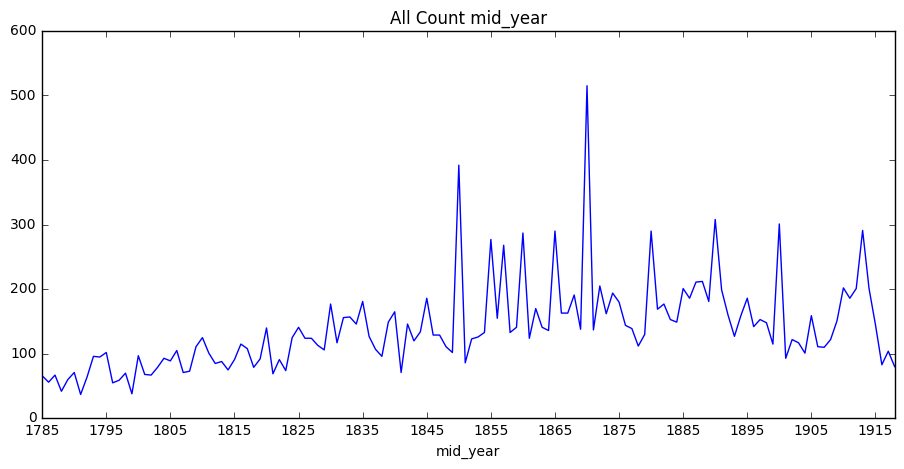

In [4]:
# plott picture_count by mid_year
plotAllCount(meta_tag_120_df)

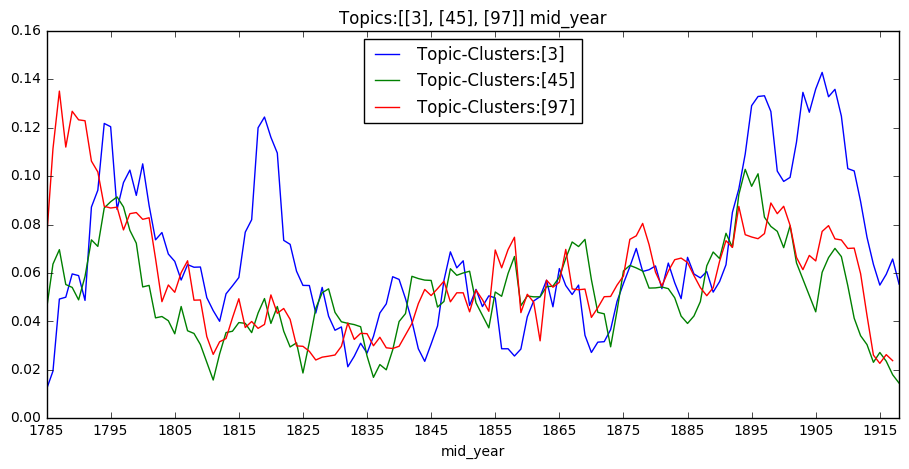

In [137]:
# krieg 62
# frau 45
# kleid, dame 97 
# religion 52, 67, 85, 96
# akt 3
# mann,kleidung 1

topicsListsWithIDs = [[3], [45], [97]]

plotTopic(topicsListsWithIDs, meta_tag_120_df)
